In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [82]:
# Imports
from os import makedirs
from os.path import join
import joblib
import numpy as np

rng_seed = 399
np.random.seed(rng_seed)
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()
from tqdm.auto import tqdm
import pandas as pd
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from nltk.corpus import wordnet as wn
import annoy
from sklearn.metrics.pairwise import euclidean_distances

import plotly.offline as pyo

pyo.init_notebook_mode()
import plotly.express as px

# Directory constants
topological_data_analysis_data_dir = "data"
topological_data_analysis_custom_data_dir = "custom_data"
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")
tps_experimentation_dir = join(output_dir, "topological_polysemy_experimentation")
analysis_of_embeddings_dir = join(root_code_dir, "analysis_of_embeddings")
output_plots_dir = join("output_plots")
makedirs(output_plots_dir, exist_ok=True)

# Extend sys path for importing custom Python files
import sys

sys.path.extend([root_code_dir, analysis_of_embeddings_dir])

from utils import (
    get_model_checkpoint_filepaths,
    pairwise_cosine_distances,
    words_to_vectors,
)
from word_embeddings.word2vec import load_model_training_output
from vis_utils import plot_word_vectors, configure_plotting_for_thesis
from topological_data_analysis.geometric_anomaly_detection import compute_gad
from analysis_utils import transform_word_embeddings

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

## Geometric anomaly detection of the Henneberg data set

In [93]:
# Load Henneberg data
henneberg_data = pd.read_csv(
    join(topological_data_analysis_custom_data_dir, "henneberg.csv"), header=None
).values
henneberg_data_dists = euclidean_distances(henneberg_data)
henneberg_tps_scores = np.load(
    join(tps_experimentation_dir, "henneberg", "tps_scores_50.npy")
)

<IPython.core.display.Javascript object>

In [94]:
henneberg_gad_result = compute_gad(
    data_points=henneberg_data.copy(order="C"),
    manifold_dimension=2,
    annulus_inner_radius=1.5,
    annulus_outer_radius=2,
    data_points_pairwise_distances=henneberg_data_dists,
    progressbar_enabled=True,
    n_jobs=-1,
)

Preparing data for multiprocessing...
Done!
Computing GAD using 20 processes...


<IPython.core.display.Javascript object>

In [95]:
# Create vector with point categories
henneberg_point_categories = np.empty(len(henneberg_data), dtype=object)
for i in range(len(henneberg_data)):
    for key in henneberg_gad_result.keys():
        if i in henneberg_gad_result[key]:
            henneberg_point_categories[i] = key

<IPython.core.display.Javascript object>

In [101]:
%matplotlib notebook

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


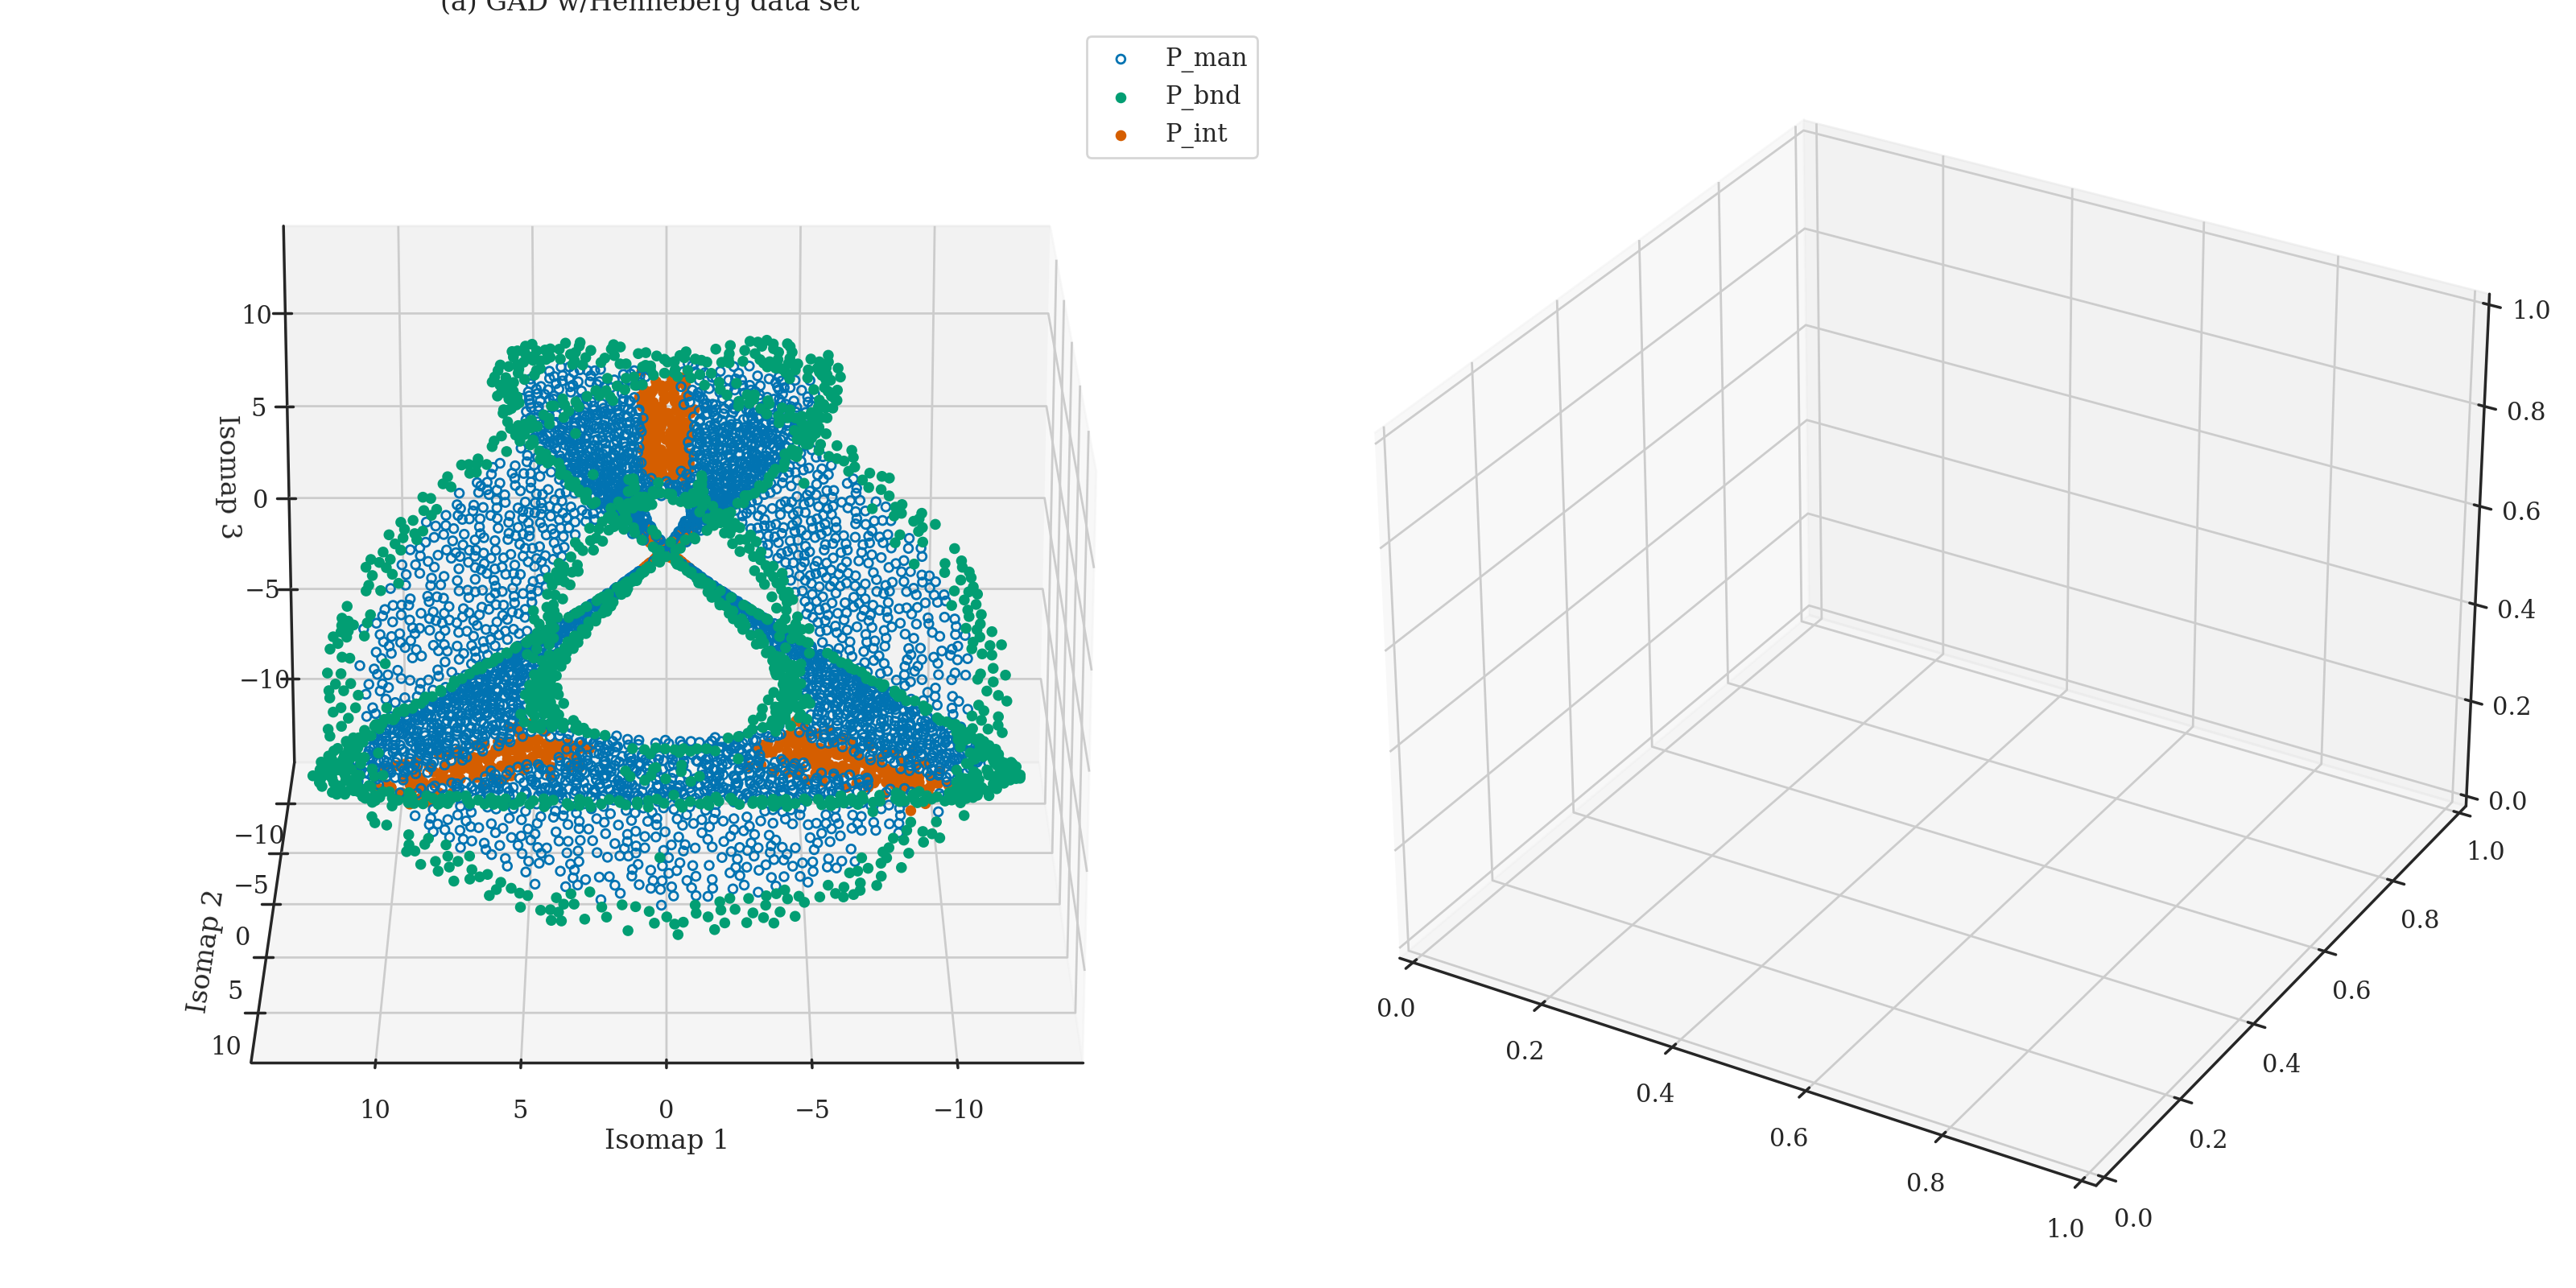

<IPython.core.display.Javascript object>

In [112]:
# Plot
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

henneberg_color_map = {"P_man": "b", "P_bnd": "g", "P_int": "r"}
for P_category, P_category_color in henneberg_color_map.items():
    P_category_indices = np.where(henneberg_point_categories == P_category)[0]
    if P_category == "P_man":
        additional_kwargs = {
            "facecolors": "none",
            "edgecolors": "b",
        }
    else:
        additional_kwargs = {
            "c": P_category_color,
        }
    scatter_handle = ax1.scatter(
        xs=henneberg_data[P_category_indices, 0],
        ys=henneberg_data[P_category_indices, 1],
        zs=henneberg_data[P_category_indices, 2],
        label=P_category,
        alpha=1,
        s=15,
        **additional_kwargs
    )

    scatter_handle.set_rasterized(True)
ax1.set_xlabel("Isomap 1")
ax1.set_ylabel("Isomap 2")
ax1.set_zlabel("Isomap 3")
ax1.set_title("(a) GAD w/Henneberg data set")
ax1.azim = 90
ax1.elev = 20
ax1.legend()

# Plot/save
save_to_pgf = False
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "gad-henneberg-3d.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

## Geometric anomaly detection of WordNet word embeddings

In [ ]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
    return_scann_instance=True,
)
last_embedding_weights_normalized = w2v_training_output["last_embedding_weights_normalized"]
last_embedding_weights_scann_instance = w2v_training_output["last_embedding_weights_scann_instance"]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]

In [7]:
print("Finding words in vocabulary with #Wordnet synsets > 0")
words_to_num_meanings = {}
for word in tqdm(words):
    num_synsets = len(wn.synsets(word))
    if num_synsets > 0:
        words_to_num_meanings[word] = num_synsets
data_words = np.array(list(words_to_num_meanings.keys()))
data_words_to_full_vocab_ints = np.array([word_to_int[word] for word in data_words])

Finding words in vocabulary with #Wordnet synsets > 0


  0%|          | 0/4430850 [00:00<?, ?it/s]

In [13]:
gad_result = compute_gad(
    data_points=last_embedding_weights_normalized,
    data_point_ints=data_words_to_full_vocab_ints,
    manifold_dimension=2,
    data_points_approx_nn=last_embedding_weights_scann_instance,
    use_knn_annulus=True,
    knn_annulus_inner=200,
    knn_annulus_outer=2000,
    progressbar_enabled=True,
    n_jobs=-1,
)

Preparing data for multiprocessing...
Done!
Computing GAD using 20 processes...


KeyboardInterrupt: 